In [1]:
from pyspark.sql import SparkSession
from pyspark.sql import SQLContext
from pyspark.sql.functions import when
from pyspark.sql.functions import col
from pyspark.sql.types import * 
from pyspark.sql.functions import lit
import pyodbc
import pandas as pd
import pyspark.sql.functions as sf


In [2]:
spark = SparkSession.builder.config("spark.driver.memory", "15g").getOrCreate()

In [33]:
def process_log_data(path,file_name,date):
    df = spark.read.json(path+file_name)
    df = df.select('_source.AppName','_source.Contract','_source.Mac','_source.TotalDuration')
    df = df.withColumn('Date',lit(date))
    df = df.withColumn('Type',
                 when((col("AppName") == 'CHANNEL') | (col("AppName") =='DSHD')| (col("AppName") =='KPLUS')| (col("AppName") =='KPlus'), "Truyền Hình")
          .when((col("AppName") == 'VOD') | (col("AppName") =='FIMS_RES')| (col("AppName") =='BHD_RES')| 
                 (col("AppName") =='VOD_RES')| (col("AppName") =='FIMS')| (col("AppName") =='BHD')| (col("AppName") =='DANET'), "Phim Truyện")
          .when((col("AppName") == 'RELAX'), "Giải Trí")
          .when((col("AppName") == 'CHILD'), "Thiếu Nhi")
          .when((col("AppName") == 'SPORT'), "Thể Thao")
          .otherwise("Error"))
    df = df.select('Contract','Type','TotalDuration','Date')
    df = df.groupBy('Contract','Type','Date').agg({'TotalDuration':'sum'}).withColumnRenamed('sum(TotalDuration)','TotalDuration')
    return df 

In [36]:
def main_task():
    path = 'C:\\Users\\ASUS\\OneDrive\\Big_Data_Analytics\\Dataset\\'
    file_name = '20220401.json'
    date = '2022-04-01'
    df = process_log_data(path,file_name,date)
    i = 2 
    while i < 10:
        file_name = '2022040{}.json'.format(i)
        date = '2022-04-0{}'.format(i)
        df1 = process_log_data(path,file_name,date)
        df = df.union(df1)
        i+= 1 
    while i <= 30: 
        file_name = '202204{}.json'.format(i)
        date = '2022-04-{}'.format(i)
        df1 = process_log_data(path,file_name,date)
        df = df.union(df1)
        i += 1 
    return df 

In [37]:
df = main_task() 
df = df.cache()

In [38]:
df.show()

+---------+-----------+----------+-------------+
| Contract|       Type|      Date|TotalDuration|
+---------+-----------+----------+-------------+
|HNJ141458|Truyền Hình|2022-04-01|        47349|
|SGJ147370|Truyền Hình|2022-04-01|        83331|
|HNFD80728|Truyền Hình|2022-04-01|        91636|
|SGH574803|Truyền Hình|2022-04-01|       113492|
|NTFD92901|Truyền Hình|2022-04-01|        18944|
|TBD015606|Phim Truyện|2022-04-01|        20586|
|AGFD54302|Truyền Hình|2022-04-01|        11860|
|SGH919014|Truyền Hình|2022-04-01|        55429|
|NTFD63152|Truyền Hình|2022-04-01|        18886|
|BTFD15886|Phim Truyện|2022-04-01|         6007|
|HND095909|Phim Truyện|2022-04-01|        16441|
|SGH209300|Truyền Hình|2022-04-01|        25527|
|NND000787|Truyền Hình|2022-04-01|          175|
|DNFD68426|Phim Truyện|2022-04-01|         3563|
|CBFD05588|Truyền Hình|2022-04-01|        62005|
|HTFD01984|Truyền Hình|2022-04-01|        81976|
|GLD014406|Truyền Hình|2022-04-01|        81937|
|DNAAA1260|Truyền Hì

In [39]:
df.select('Date').distinct().count()

30

In [59]:
daily_statistic = df.groupBy('Date','Type').agg({'TotalDuration':'sum','Contract':'count'}).withColumnRenamed('sum(TotalDuration)','TotalDuration').withColumnRenamed('count(Contract)','TotalUsers')

In [60]:
daily_statistic.show()

+----------+-----------+----------+-------------+
|      Date|       Type|TotalUsers|TotalDuration|
+----------+-----------+----------+-------------+
|2022-04-17|Phim Truyện|     88125|    631493752|
|2022-04-08|Phim Truyện|     83577|    563753952|
|2022-04-01|Phim Truyện|     86312|    627150472|
|2022-04-16|   Giải Trí|      7110|     20614789|
|2022-04-05|   Thể Thao|      2202|      1203614|
|2022-04-02|   Giải Trí|     14183|     23660631|
|2022-04-06|Phim Truyện|     81478|   -250954961|
|2022-04-10|Truyền Hình|   1275622|  23801151939|
|2022-04-13|Truyền Hình|   1329482|  24323390206|
|2022-04-18|   Thể Thao|      3761|      5775137|
|2022-04-03|Phim Truyện|     88953|    669111655|
|2022-04-22|   Thể Thao|      2643|      1617107|
|2022-04-19|   Thể Thao|      2921|      1806384|
|2022-04-30|   Giải Trí|     11554|     16848576|
|2022-04-25|Truyền Hình|   1322348|  24934009990|
|2022-04-03|   Thể Thao|      2601|      2089684|
|2022-04-27|   Giải Trí|     12996|     16509577|


In [61]:
daily_statistics = daily_statistic.withColumn('TotalDuration',col('TotalDuration')/3600)

In [62]:
daily_statistics.show()

+----------+-----------+----------+------------------+
|      Date|       Type|TotalUsers|     TotalDuration|
+----------+-----------+----------+------------------+
|2022-04-17|Phim Truyện|     88125| 175414.9311111111|
|2022-04-08|Phim Truyện|     83577|         156598.32|
|2022-04-01|Phim Truyện|     86312|174208.46444444446|
|2022-04-16|   Giải Trí|      7110| 5726.330277777778|
|2022-04-05|   Thể Thao|      2202|334.33722222222224|
|2022-04-02|   Giải Trí|     14183|         6572.3975|
|2022-04-06|Phim Truyện|     81478|-69709.71138888889|
|2022-04-10|Truyền Hình|   1275622| 6611431.094166666|
|2022-04-13|Truyền Hình|   1329482| 6756497.279444444|
|2022-04-18|   Thể Thao|      3761|1604.2047222222222|
|2022-04-03|Phim Truyện|     88953| 185864.3486111111|
|2022-04-22|   Thể Thao|      2643|449.19638888888886|
|2022-04-19|   Thể Thao|      2921| 501.7733333333333|
|2022-04-30|   Giải Trí|     11554|           4680.16|
|2022-04-25|Truyền Hình|   1322348| 6926113.886111111|
|2022-04-0

In [65]:
df.repartition(1).write.csv('C:\\Users\\ASUS\\OneDrive\\Big_Data_Analytics\\BigData_Gen2\\Class 4\\DF_clean',header=True)

In [64]:
daily_statistic.repartition(1).write.csv('C:\\Users\\ASUS\\OneDrive\\Big_Data_Analytics\\BigData_Gen2\\Class 4\\Daily_Statistic',header=True)

<h1> Descriptive Statistics daily <h1> 

In [44]:
visual_1 = daily_statistics.toPandas()

In [45]:
visual_1 = visual_1.sort_values(by = 'Date', ascending = True)

In [46]:
import seaborn as sns 
import matplotlib.pyplot as plt

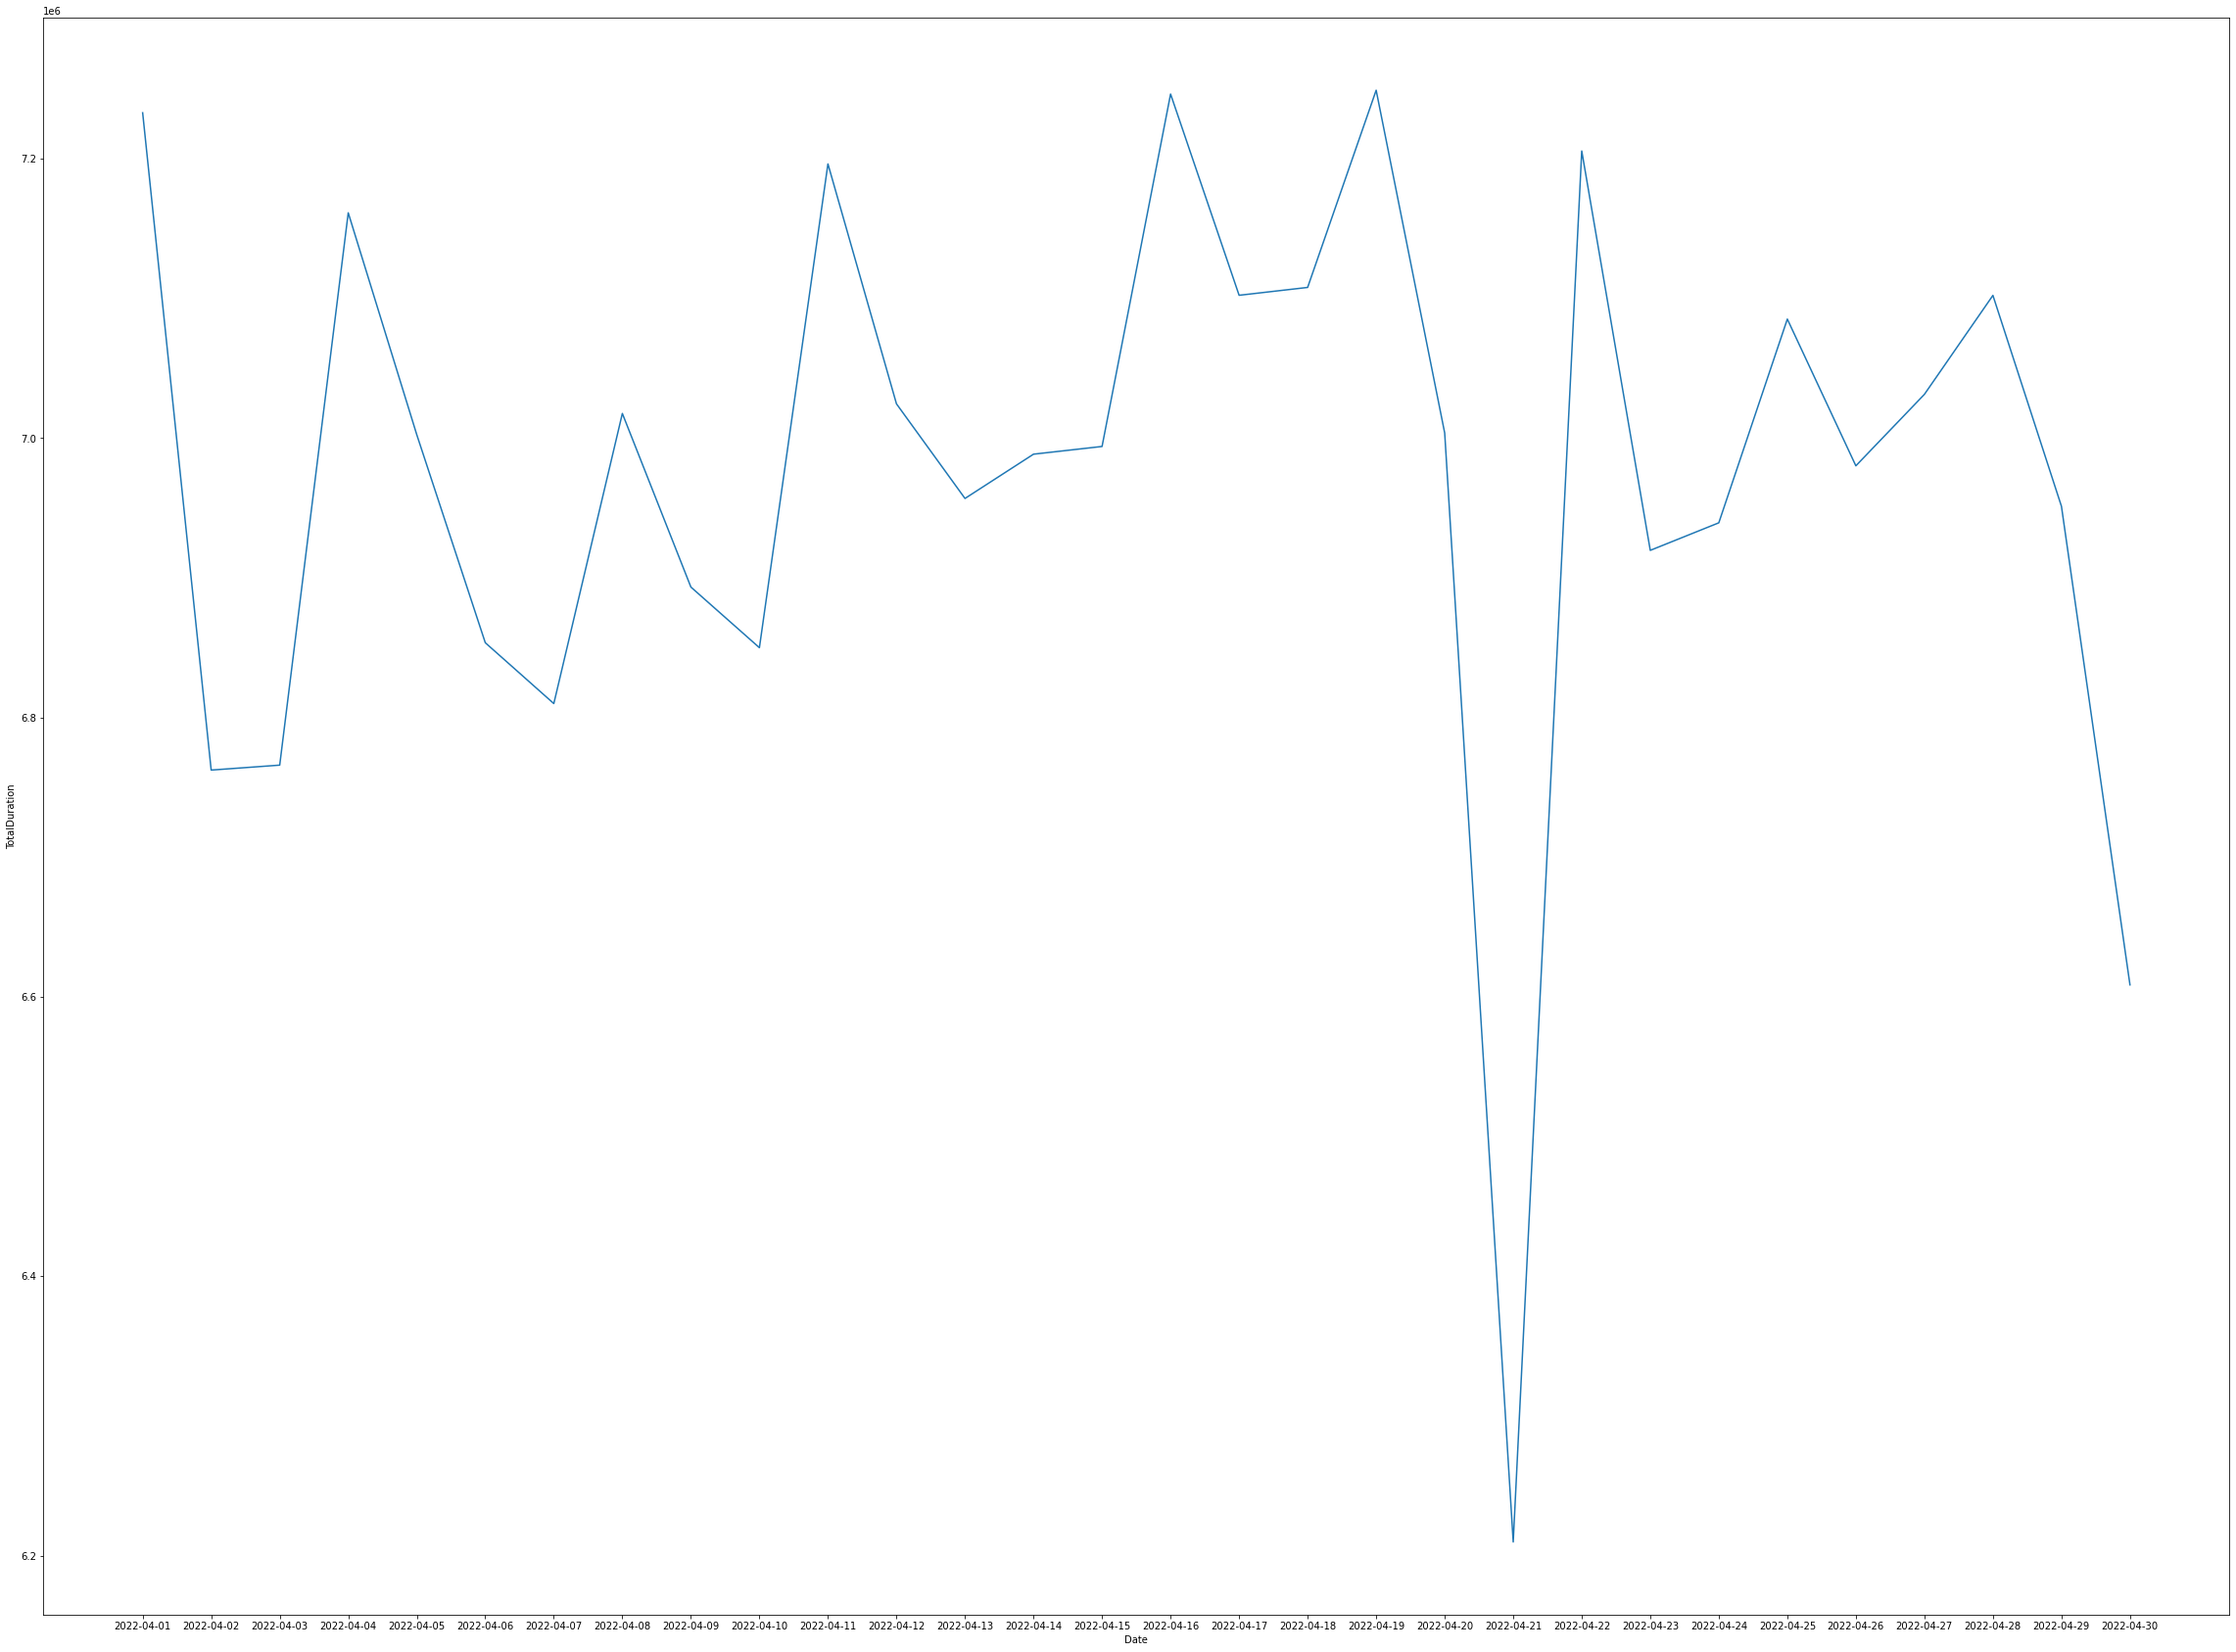

In [52]:
plt.figure(figsize=(40,30))
sns.lineplot(data = visual_1 , x = 'Date' , y ='TotalDuration')

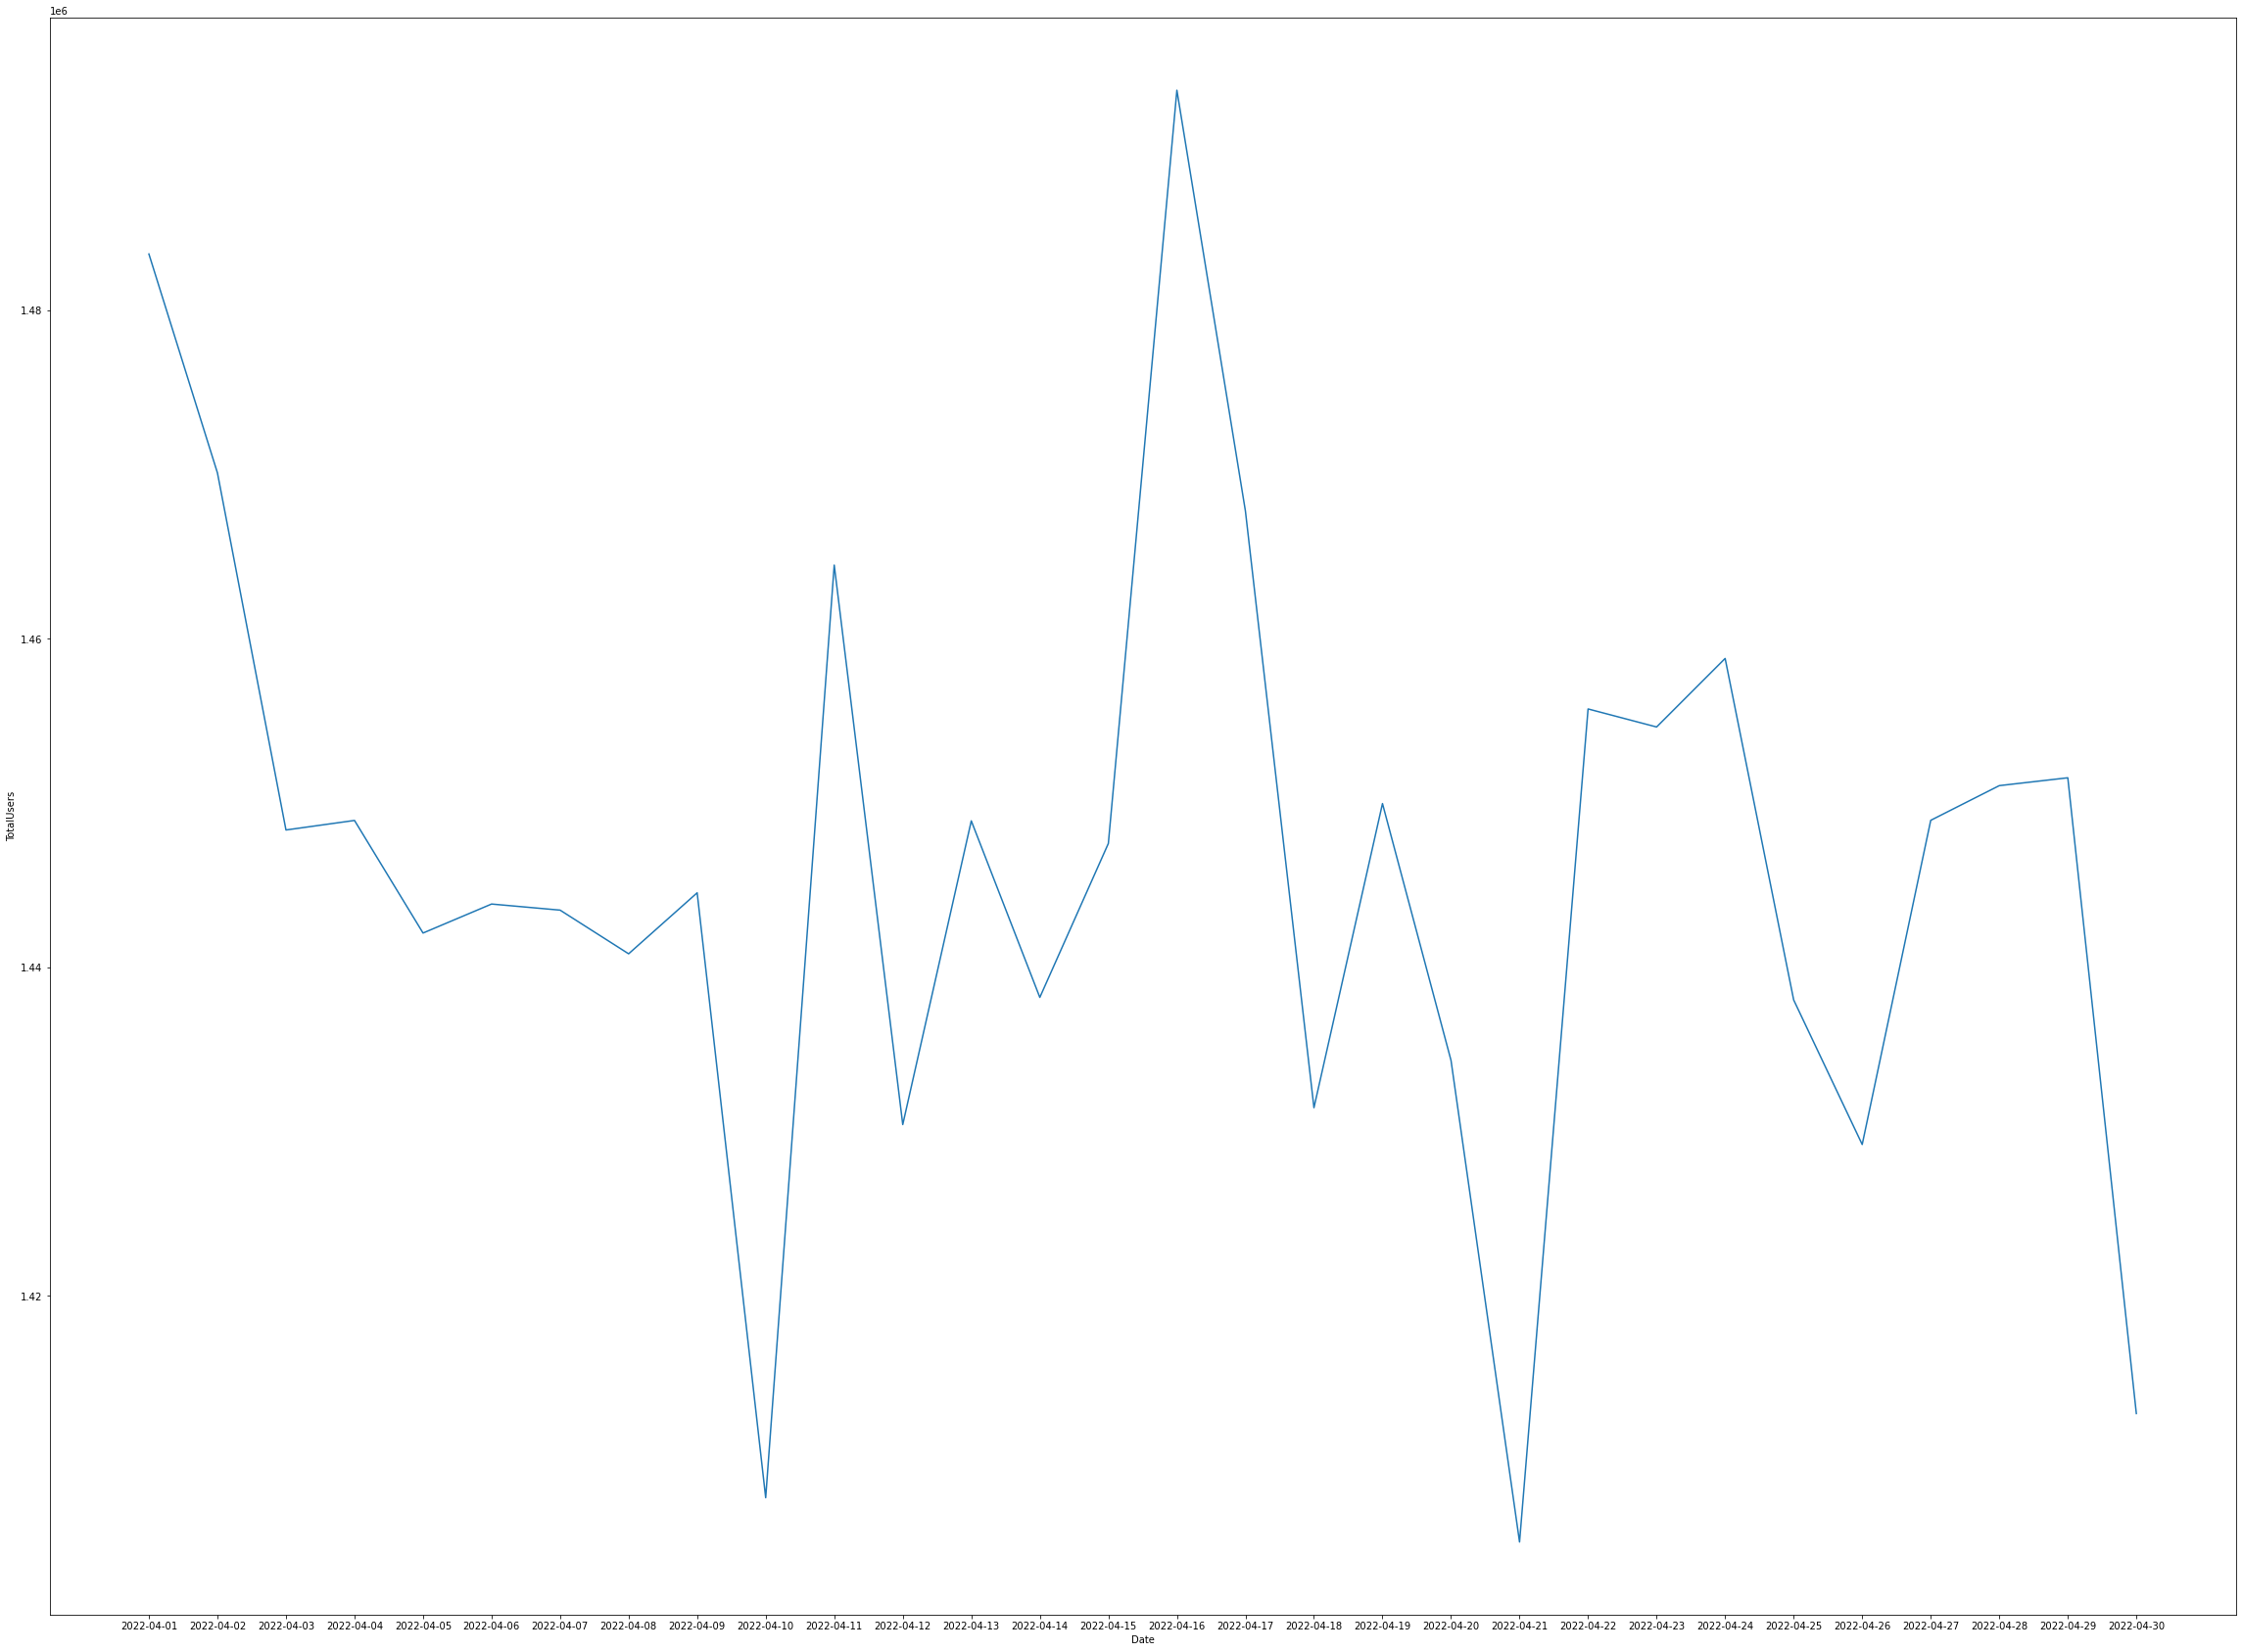

In [53]:
plt.figure(figsize=(40,30))
sns.lineplot(data = visual_1 , x = 'Date' , y ='TotalUsers')

In [54]:
df.show()

+---------+-----------+----------+-------------+
| Contract|       Type|      Date|TotalDuration|
+---------+-----------+----------+-------------+
|HNJ141458|Truyền Hình|2022-04-01|        47349|
|SGJ147370|Truyền Hình|2022-04-01|        83331|
|HNFD80728|Truyền Hình|2022-04-01|        91636|
|SGH574803|Truyền Hình|2022-04-01|       113492|
|NTFD92901|Truyền Hình|2022-04-01|        18944|
|TBD015606|Phim Truyện|2022-04-01|        20586|
|AGFD54302|Truyền Hình|2022-04-01|        11860|
|SGH919014|Truyền Hình|2022-04-01|        55429|
|NTFD63152|Truyền Hình|2022-04-01|        18886|
|BTFD15886|Phim Truyện|2022-04-01|         6007|
|HND095909|Phim Truyện|2022-04-01|        16441|
|SGH209300|Truyền Hình|2022-04-01|        25527|
|NND000787|Truyền Hình|2022-04-01|          175|
|DNFD68426|Phim Truyện|2022-04-01|         3563|
|CBFD05588|Truyền Hình|2022-04-01|        62005|
|HTFD01984|Truyền Hình|2022-04-01|        81976|
|GLD014406|Truyền Hình|2022-04-01|        81937|
|DNAAA1260|Truyền Hì

In [55]:
df.count()

43385699

In [56]:
df.select('Contract').count()

43385699

In [57]:
df.select('Contract').distinct().count()

1920546

<h1> Individual Customer Statistics <h1> 

In [70]:
df.printSchema()

root
 |-- Contract: string (nullable = true)
 |-- Type: string (nullable = false)
 |-- TotalDuration: long (nullable = true)



In [69]:
df = df.drop('Date')

In [72]:
df = df.groupBy('Contract','Type').agg({'TotalDuration':'sum'}).withColumnRenamed('sum(TotalDuration)','TotalDuration')

In [73]:
df.show()

+---------+-----------+-------------+
| Contract|       Type|TotalDuration|
+---------+-----------+-------------+
|BNFD59512|Truyền Hình|       153698|
|TVFD16705|Truyền Hình|        44385|
|HPFD98012|Truyền Hình|       133127|
|DNH022378|Truyền Hình|      2092483|
|QNFD70139|Truyền Hình|       191407|
|HNH775587|Truyền Hình|       131193|
|SGH534557|Truyền Hình|       393271|
|BEFD03370|   Giải Trí|         6550|
|KTFD03928|Phim Truyện|         7409|
|SGH694318|Truyền Hình|       891425|
|HNH480736|Truyền Hình|       734792|
|HPFD59060|Truyền Hình|       147633|
|HNH643441|Truyền Hình|       100405|
|LAFD14563|Truyền Hình|       287877|
|QAD014188|Truyền Hình|       410384|
|BDD054548|Truyền Hình|       637793|
|TBD018795|Truyền Hình|       350296|
|HNH760579|Truyền Hình|       303952|
|GLAAA0362|Truyền Hình|       504477|
|SGH978411|Truyền Hình|       103046|
+---------+-----------+-------------+
only showing top 20 rows

